In [1]:
%matplotlib inline
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [3]:
#del cnn
torch.cuda.empty_cache()
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [4]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [5]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [6]:
STYLE_LAYERS_TRANSLATION = {'conv_1': 'conv1_1',
                            'conv_2': 'conv1_2',

                            'conv_3': 'conv2_1',
                            'conv_4': 'conv2_2',

                            'conv_5': 'conv3_1',
                            'conv_6': 'conv3_2',
                            'conv_7': 'conv3_3',
                            'conv_8': 'conv3_4',

                            'conv_9': 'conv4_1',
                            'conv_10': 'conv4_2',
                            'conv_11': 'conv4_3',
                            'conv_12': 'conv4_4',

                            'conv_13': 'conv5_1',
                            'conv_14': 'conv5_2',
                            'conv_15': 'conv5_3',
                            'conv_16': 'conv5_4'}

# ====================



In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# ====================

In [8]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

#GAUSSIAN_BLUR = 8

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name) #.convert('RGB')
    #image = image.filter(ImageFilter.GaussianBlur(GAUSSIAN_BLUR))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/starry_night_full.jpg")
#content_img = image_loader("./images/.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

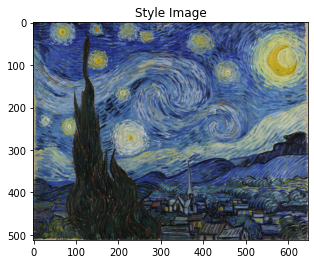

In [9]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, title):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(title)

plt.figure()
imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [10]:
# class ContentLoss(nn.Module):

#     def __init__(self, target,):
#         super(ContentLoss, self).__init__()
#         # we 'detach' the target content from the tree used
#         # to dynamically compute the gradient: this is a stated value,
#         # not a variable. Otherwise the forward method of the criterion
#         # will throw an error.
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input

In [11]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, #content_img,
                               #content_layers,
                               style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
#     content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      

        model.add_module(name, layer)

#         if name in content_layers:
#             # add content loss:
#             target = model(content_img).detach()
#             content_loss = ContentLoss(target)
#             model.add_module("content_loss_{}".format(i), content_loss)
#             content_losses.append(content_loss)

        if name.startswith('conv') and STYLE_LAYERS_TRANSLATION[name] in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss): #or isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses#, content_losses

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    # optimizer = optim.Adam([target], lr=0.003)
    return optimizer

In [54]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       #content_img, 
                       style_img, input_img,
                       style_layers, style_weights,
                       num_steps=300, style_weight=1000000):#, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
#     model, style_losses, content_losses = get_style_model_and_losses(cnn,
    model, style_losses = get_style_model_and_losses(cnn, 
        normalization_mean, normalization_std, style_img, style_layers)#, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    losses = []
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
#             content_score = 0

            for i, sl in enumerate(style_losses):
                style_score += style_weights[i] * sl.loss
#             for cl in content_losses:
#                 content_score += cl.loss

            style_score *= style_weight
#             content_score *= content_weight

            loss = style_score # + content_score
            losses.append(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:\t\tStyle loss: {:4f}".format(run, style_score.item()))
#                 print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                     style_score.item(), content_score.item()))
                #print('Style Loss : {:4f} '.format(style_score.item()))
                #print()
            if run[0] % 500 == 0:
                vis_img = copy.deepcopy(input_img)
                plt.figure()
                imshow(vis_img, title=f'On run {run[0]}')
        
            return style_score #+ content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img, losses

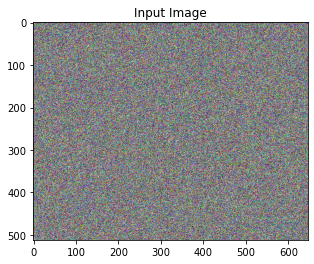

In [14]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
base_img = torch.randn(style_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(base_img, title='Input Image')

Building the style transfer model..
Optimizing..


F:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
F:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:		Style loss: 441.676819
run [100]:		Style loss: 94.816269
run [150]:		Style loss: 50.985298
run [200]:		Style loss: 36.124386
run [250]:		Style loss: 28.083284
run [300]:		Style loss: 23.088936
run [350]:		Style loss: 19.609900
run [400]:		Style loss: 17.045534
run [450]:		Style loss: 15.122213
run [500]:		Style loss: 13.642840


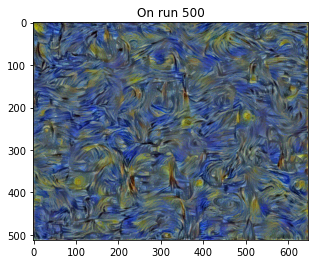

run [550]:		Style loss: 12.436592
run [600]:		Style loss: 11.496331
run [650]:		Style loss: 10.601086
run [700]:		Style loss: 9.687964
run [750]:		Style loss: 8.800291
run [800]:		Style loss: 7.910215
run [850]:		Style loss: 7.010652
run [900]:		Style loss: 6.130967
run [950]:		Style loss: 5.312126
run [1000]:		Style loss: 4.525922


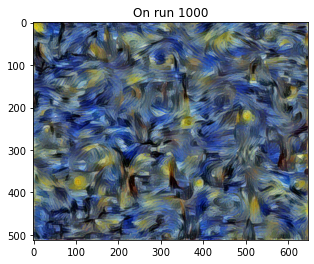

run [1050]:		Style loss: 3.790979
run [1100]:		Style loss: 3.142062
run [1150]:		Style loss: 2.627039
run [1200]:		Style loss: 2.148473
run [1250]:		Style loss: 1.773102
run [1300]:		Style loss: 1.470543
run [1350]:		Style loss: 1.212398
run [1400]:		Style loss: 1.039021
run [1450]:		Style loss: 0.880905
run [1500]:		Style loss: 0.758588


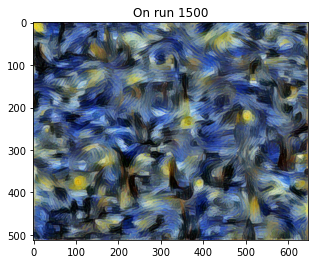

run [1550]:		Style loss: 0.651609
run [1600]:		Style loss: 0.572634
run [1650]:		Style loss: 0.507536
run [1700]:		Style loss: 0.451398
run [1750]:		Style loss: 0.408264
run [1800]:		Style loss: 0.371145
run [1850]:		Style loss: 0.339313
run [1900]:		Style loss: 0.312112
run [1950]:		Style loss: 0.289750
run [2000]:		Style loss: 0.270014


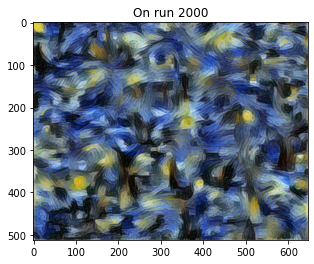

run [2050]:		Style loss: 0.252000
run [2100]:		Style loss: 0.236953
run [2150]:		Style loss: 0.224056
run [2200]:		Style loss: 0.211799
run [2250]:		Style loss: 0.201185
run [2300]:		Style loss: 0.191400
run [2350]:		Style loss: 0.181727
run [2400]:		Style loss: 0.173320
run [2450]:		Style loss: 0.166141
run [2500]:		Style loss: 0.159393


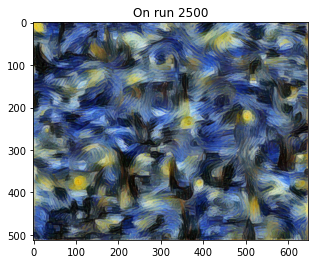

run [2550]:		Style loss: 0.152899
run [2600]:		Style loss: 0.146639
run [2650]:		Style loss: 0.140962
run [2700]:		Style loss: 0.135752
run [2750]:		Style loss: 0.130680
run [2800]:		Style loss: 0.126257
run [2850]:		Style loss: 0.122011
run [2900]:		Style loss: 0.117788
run [2950]:		Style loss: 0.114120
run [3000]:		Style loss: 0.110499


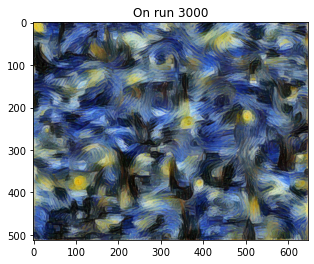

run [3050]:		Style loss: 0.107242
run [3100]:		Style loss: 0.103923
run [3150]:		Style loss: 0.100908
run [3200]:		Style loss: 0.098290
run [3250]:		Style loss: 0.095572
run [3300]:		Style loss: 0.093019
run [3350]:		Style loss: 0.090624
run [3400]:		Style loss: 0.088173
run [3450]:		Style loss: 0.085881
run [3500]:		Style loss: 0.083614


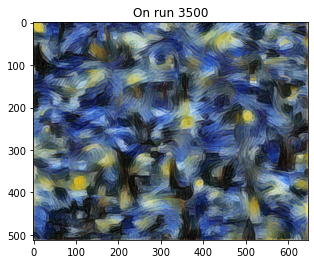

run [3550]:		Style loss: 0.081688
run [3600]:		Style loss: 0.079712
run [3650]:		Style loss: 0.077701
run [3700]:		Style loss: 0.075873
run [3750]:		Style loss: 0.074246
run [3800]:		Style loss: 0.072603
run [3850]:		Style loss: 0.071084
run [3900]:		Style loss: 0.069453
run [3950]:		Style loss: 0.068008
run [4000]:		Style loss: 0.066572


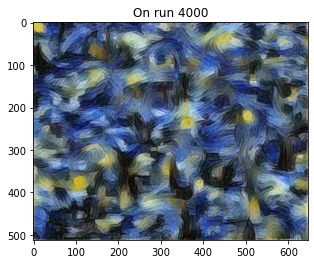

run [4050]:		Style loss: 0.065257
run [4100]:		Style loss: 0.063947
run [4150]:		Style loss: 0.062679
run [4200]:		Style loss: 0.061483
run [4250]:		Style loss: 0.060281
run [4300]:		Style loss: 0.059113
run [4350]:		Style loss: 0.058037
run [4400]:		Style loss: 0.056998
run [4450]:		Style loss: 0.055987
run [4500]:		Style loss: 0.054968


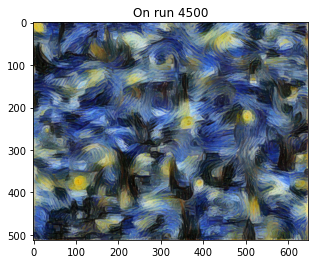

run [4550]:		Style loss: 0.054038
run [4600]:		Style loss: 0.053185
run [4650]:		Style loss: 0.052321
run [4700]:		Style loss: 0.051518
run [4750]:		Style loss: 0.050764
run [4800]:		Style loss: 0.049988
run [4850]:		Style loss: 0.049213
run [4900]:		Style loss: 0.048464
run [4950]:		Style loss: 0.047753
run [5000]:		Style loss: 0.047080


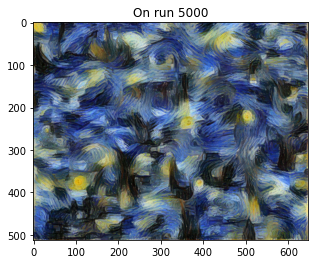

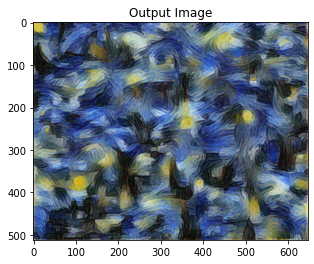

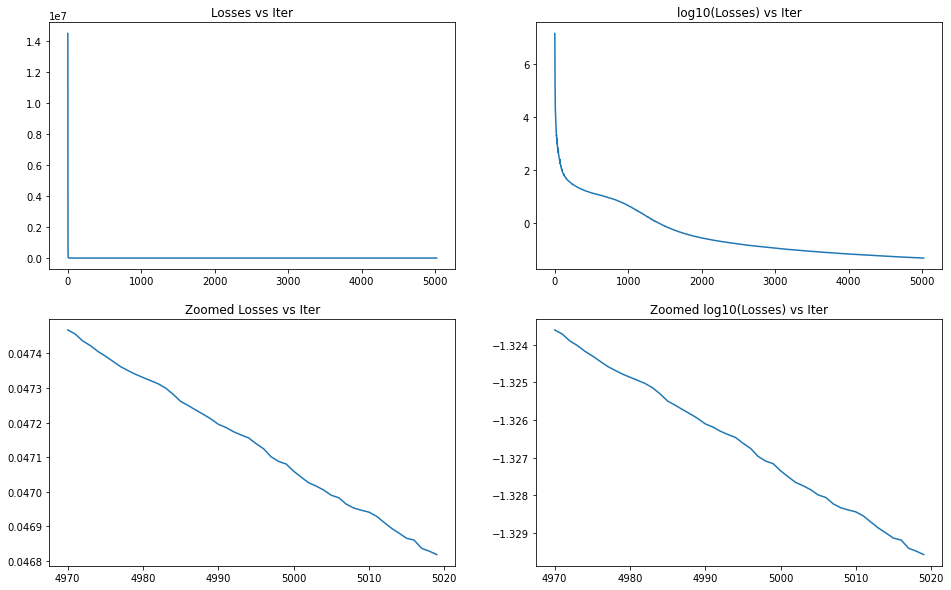

In [55]:
input_img = copy.deepcopy(base_img)

STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']#, 'conv5_1']#, 'conv_3', 'conv_4', 'conv_5']
# STYLE_LAYERS = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8']
STYLE_WEIGHTS = np.array([10,5,1,1,1])
# STYLE_WEIGHTS = np.ones(len(STYLE_LAYERS))
EPOCHS = 5000

output, losses = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, 
                            style_img, input_img,  
                            STYLE_LAYERS, STYLE_WEIGHTS,
                            num_steps=EPOCHS)

plt.figure()
imshow(output, title='Output Image')

fig = plt.figure(figsize=(16,10))
fig.add_subplot(2,2,1)
plt.plot(losses) 
plt.title('Losses vs Iter')
fig.add_subplot(2,2,2)
plt.plot(np.log10(losses)) 
plt.title('log10(Losses) vs Iter')
fig.add_subplot(2,2,3)
plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
plt.title('Zoomed Losses vs Iter')
fig.add_subplot(2,2,4)
plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
plt.title('Zoomed log10(Losses) vs Iter')

imsave(output, f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
fig.savefig(f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [40]:
# a = copy.deepcopy(output)
# imshow(output-a, title='Sub Img')
#imsave(output, f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
# fig = plt.figure(figsize=(18,10))
# fig.add_subplot(2,2,1)
# plt.plot(losses) 
# plt.title('Losses vs Iter')
# fig.add_subplot(2,2,2)
# plt.plot(np.log10(losses)) 
# plt.title('log10(Losses) vs Iter')
# fig.add_subplot(2,2,3)
# plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
# plt.title('Zoomed Losses vs Iter')
# fig.add_subplot(2,2,4)
# plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
# plt.title('Zoomed log10(Losses) vs Iter')
# fig.savefig(f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

In [22]:
%qtconsole